# <center> <h1>Text mining with Latent Dirichlet Allocation - LDA</h1> </center>


<img src="../images/dirichlet_distrib.png" width="200">

# Presentation of LDA

#### The use-case

First we observe a corpus $D$ of $M$ documents. Each document is composed of $N_i$ words.

<img src="../images/LDA_doc_words.png" width="600">

To synthetize information on each document we make the assumtion that there exists $K$ latents topics, such as each document in a distribution of topics and each topic is a distribution of words.

<img src="../images/LDA_topics.png" width="600">

The problem is that we would like to know :
* the ditribution $ \phi_k$ of word in each topic $k$, so that we can interpret the mining of a topic
* the ditribution $ \theta_d$ of topic in each document $d$, so that we can understand the main messages of each document

#### The solution

First of all we consider a model that represent the way the corpus is built up. 

Step 1 : for each document $d$ the distribution of topics is $\theta_d \sim Dir(\alpha)$

Step 2 : for each topic $k$ the distribution of words is $\phi_k \sim Dir(\beta)$

Step 3 : for each position $(i,j)$ (position $j$ in the document $i$, where $j \in \{1,...,N_i\}$ and $i \in \{1,...,M\}$),
* choose a topic $z_{(i,j)} \sim Multinomial(\theta_i)$
* then choose a word $w_{(i,j)} \sim Multinomial(\phi_{z_{(i,j)}})$

<img src="../images/LDA_topic_word.png" width="600">

Then we fit the model to the actual corpus and interpret the mining of the topics and the documents.

# Get the data (this can take a while)

The data corresponds to 25,000 highly polar movie reviews posted on the website Imdb. To know more about it, you can visit this page : http://ai.stanford.edu/~amaas/data/sentiment/.

Import the folder tar.gz

In [1]:
import requests

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = url.split("/")[-1]

with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

Unzip the folder

In [2]:
import tarfile 

tar = tarfile.open(filename, "r:gz")
tar.extractall()
tar.close()

Get the files' names

In [3]:
import glob
path = "./aclImdb/train/pos"
files_pos = [f for f in glob.glob(path + "**/*.txt", recursive=True)]
path = "./aclImdb/train/neg"
files_neg = [f for f in glob.glob(path + "**/*.txt", recursive=True)]

Get a sample of the data

In [4]:
sample_size = 500

import numpy as np
files_pos_sample = zip(np.random.choice(files_pos, sample_size, replace=False),
                       np.repeat("pos",sample_size))
files_neg_sample = zip(np.random.choice(files_neg, sample_size, replace=False),
                       np.repeat("neg",sample_size))

files_sample = list(files_pos_sample) + list(files_neg_sample)

In [5]:
import pandas as pd
data_text = pd.DataFrame(columns={"text","sentiment"})

for item in files_sample :
    try:
        text = open(item[0], "r").read()
        sentiment = item[1]
        data_text = data_text.append(pd.DataFrame({"text": [text],"sentiment":[sentiment]}),sort=True)
    except:
        print("One file cand'be loaded")

In [6]:
data_text = data_text.reset_index().drop("index",axis=1)

In [7]:
data_text.to_csv("data_sample")

In [8]:
data_text = pd.read_csv("data_sample", index_col=0)

## Cleaning the data

Cleaning the punctuation signs and uppercase characters

In [9]:
import re

data_text["text"] = data_text["text"].map(lambda x: re.sub('[,\.!?]()<>',' ', x))\
                                     .map(lambda x: x.lower())

First visualization with a wordcloud

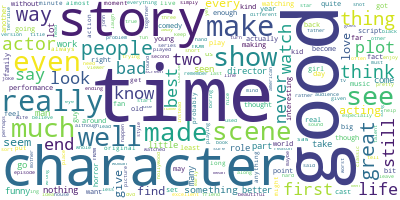

In [10]:
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(data_text['text']))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, contour_color='steelblue')

# remove some common and not interestign words
long_string = re.sub('film','',long_string)
long_string = re.sub('br','',long_string)
long_string = re.sub('movie','',long_string)
long_string = re.sub('will','',long_string)
long_string = re.sub('one','',long_string)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [12]:
from sklearn.feature_extraction import text 

#make stop word list
additional_stop_words = ['film','br','movie','will','one']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

#set the CountVectorizer
count_vectorizer = CountVectorizer(stop_words=stop_words)
count_data = count_vectorizer.fit_transform(data_text['text'])
words = count_vectorizer.get_feature_names()

total_counts = np.zeros(len(words))

for t in count_data:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))

# LDA model

In [13]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

number_topics = 5
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [14]:
for topic_idx, topic in enumerate(lda.components_):
    print("#Topic{}".format(topic_idx+1))
    print(" ".join([words[ii] for ii in topic.argsort()[:-number_words-1:-1]]))
    print("\n")

#Topic1
just time like good don really watch story way life


#Topic2
like people great good game just story best make didn


#Topic3
like story good just really scenes movies time films make


#Topic4
like good just time story bad think great make really


#Topic5
like just really good story time people character great bad




### Get the data of the model ditributions

In [18]:
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

#### Save the html page

In [19]:
html_filename = './ldavis_prepared_'+ str(number_topics) +'.html'
pyLDAvis.save_html(LDAvis_prepared, html_filename)

The page can be embedded and diplayed here. But one could prefer display it in here browser.

In [20]:
from IPython.display import IFrame
IFrame(src=html_filename, width=900, height=900)

Sources :

https://machinelearningmastery.com/clean-text-machine-learning-python/

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}